## Importing and mapping netCDF data with xarray and cartopy

- Read data from a netCDF file with xarray
- Select (index) and modify variables using xarray
- Create user-defined functions
- Set up map features with cartopy (lat/lon tickmarks, continents, country/state borders); create a function to automate these steps
- Overlay various plot types: contour lines, filled contours, vectors, and barbs
- Customize plot elements such as the colorbar and titles
- Save figure
    

In [2]:
## Imports

import os, sys
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


### Load netcdf data with Xarray

This example demonstrates importing and mapping ERA5 reanalysis data for an AR-Thunderstorm event that occurred in Santa Barbara County on 6 March 2019. The data file created for this example can be found in the `sample-data` folder that 6-hourly ERA5 Reanalysis on a 0.5 x 0.5 deg lat-lon grid  4-8 March. ERA5 data was retrieved from the Climate Data Store and subset to a regional domain over the Western US/N. Pacific. 

The xarray package provides an easy interface for importing and analyzing multidimensional data. Because xarray was designed around the netCDF data model, it is an exceptionally powerful tool for working with weather and climate data.


Xarray has two fundamental **data structures**:  

**1)** a **`DataArray`**, which holds a single n-dimensional variable. Elements of a DataArray include:
   - `values`: numpy array of data values
   - `dims`: list of named dimensions (for example, `['time','lat','lon']`)
   - `coords`: coordinate arrays (e.g., vectors of lat/lon values or datetime data)
   - `atts`: variable attributes such as `units` and `standard_name`   
    
**2)** a **`Dataset`**, which holds multiple n-dimensional variables (shared coordinates). Elements of a Dataset: data variables, dimensions, coordinates, and attributes.


In the cell below, we will load the ERA5 data (netcdf file) into an xarray dataset.


In [3]:
# Path to ERA5 data
filepath = "../sample-data/era5.6hr.AR-thunderstorm.20190304_08.nc"

# Read nc file into xarray dataset
ds = xr.open_dataset(filepath)

# Print dataset contents 
print(ds)


<xarray.Dataset>
Dimensions:    (latitude: 61, level: 3, longitude: 91, time: 20)
Coordinates:
  * longitude  (longitude) float32 -145.0 -144.5 -144.0 ... -101.0 -100.5 -100.0
  * latitude   (latitude) float32 52.0 51.5 51.0 50.5 ... 23.5 23.0 22.5 22.0
  * level      (level) float64 250.0 500.0 850.0
  * time       (time) datetime64[ns] 2019-03-04 ... 2019-03-08T18:00:00
Data variables:
    zg         (time, level, latitude, longitude) float64 ...
    u          (time, level, latitude, longitude) float64 ...
    v          (time, level, latitude, longitude) float64 ...
    msl        (time, latitude, longitude) float64 ...
    prec       (time, latitude, longitude) float64 ...
Attributes:
    CDI:                       Climate Data Interface version 1.8.2 (http://m...
    Conventions:               CF-1.6
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.8.2 (http://m...
    title:                     

### Selecting/Indexing data with xarray

We can always use regular numpy indexing and slicing on DataArrays and Datasets; however, 
it is often more powerful and easier to use xarray’s `.sel()` method of label-based indexing.


In [4]:
# Select a single time

ds.sel(time='2019-03-05T18:00:00')   # 5 March 2019 at 18 UTC


<xarray.Dataset>
Dimensions:    (latitude: 61, level: 3, longitude: 91)
Coordinates:
  * longitude  (longitude) float32 -145.0 -144.5 -144.0 ... -101.0 -100.5 -100.0
  * latitude   (latitude) float32 52.0 51.5 51.0 50.5 ... 23.5 23.0 22.5 22.0
  * level      (level) float64 250.0 500.0 850.0
    time       datetime64[ns] 2019-03-05T18:00:00
Data variables:
    zg         (level, latitude, longitude) float64 ...
    u          (level, latitude, longitude) float64 ...
    v          (level, latitude, longitude) float64 ...
    msl        (latitude, longitude) float64 ...
    prec       (latitude, longitude) float64 ...
Attributes:
    CDI:                       Climate Data Interface version 1.8.2 (http://m...
    Conventions:               CF-1.6
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.8.2 (http://m...
    title:                     ERA5 Reanalysis
    institution:               European Centre for Medium-Range Weather Forec...
    grid_resolution:           0.5 x 0.5 deg lat-lon
    frequency:                 6 hours

In [7]:
# Select all times within a single day 

ds.sel(time='2019-03-06')


<xarray.Dataset>
Dimensions:    (latitude: 61, level: 3, longitude: 91, time: 4)
Coordinates:
  * longitude  (longitude) float32 -145.0 -144.5 -144.0 ... -101.0 -100.5 -100.0
  * latitude   (latitude) float32 52.0 51.5 51.0 50.5 ... 23.5 23.0 22.5 22.0
  * level      (level) float64 250.0 500.0 850.0
  * time       (time) datetime64[ns] 2019-03-06 ... 2019-03-06T18:00:00
Data variables:
    zg         (time, level, latitude, longitude) float64 ...
    u          (time, level, latitude, longitude) float64 ...
    v          (time, level, latitude, longitude) float64 ...
    msl        (time, latitude, longitude) float64 ...
    prec       (time, latitude, longitude) float64 ...
Attributes:
    CDI:                       Climate Data Interface version 1.8.2 (http://m...
    Conventions:               CF-1.6
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.8.2 (http://m...
    title:                     ERA5 Reanalysis
    institution:               European Centre for Medium-Range Weather Forec...
    grid_resolution:           0.5 x 0.5 deg lat-lon
    frequency:                 6 hours

In [10]:
# Select times at 06 UTC

idx = (ds['time.hour'] == 6)  # selection uses boolean indexing
hr06 = ds.sel(time=idx)       # statements could be combined into a single line

print(hr06)
print(hr06.time.values)  # check time coordinates in new dataset

['2019-03-04T06:00:00.000000000' '2019-03-05T06:00:00.000000000'
 '2019-03-06T06:00:00.000000000' '2019-03-07T06:00:00.000000000'
 '2019-03-08T06:00:00.000000000']


In the previous block, we used the `ds['time.hour']` to access the 'hour' component of a datetime object. Other datetime components include 'year', 'month', 'day', 'dayofyear', and 'season'. The 'season' component is unqiue to xarray; valid seasons include 'DJF', 'MAM', 'JJA', and 'SON'.

In [12]:
# Select a single grid point

ds.sel(latitude=40, longitude=-120)


<xarray.Dataset>
Dimensions:    (level: 3, time: 20)
Coordinates:
    longitude  float32 -120.0
    latitude   float32 40.0
  * level      (level) float64 250.0 500.0 850.0
  * time       (time) datetime64[ns] 2019-03-04 ... 2019-03-08T18:00:00
Data variables:
    zg         (time, level) float64 ...
    u          (time, level) float64 ...
    v          (time, level) float64 ...
    msl        (time) float64 ...
    prec       (time) float64 ...
Attributes:
    CDI:                       Climate Data Interface version 1.8.2 (http://m...
    Conventions:               CF-1.6
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.8.2 (http://m...
    title:                     ERA5 Reanalysis
    institution:               European Centre for Medium-Range Weather Forec...
    grid_resolution:           0.5 x 0.5 deg lat-lon
    frequency:                 6 hours

In [13]:
# Select the grid point nearest to 34.4208° N, 119.6982°W;

ds.sel(latitude=34.4208, longitude=-119.6982, method='nearest')


<xarray.Dataset>
Dimensions:    (level: 3, time: 20)
Coordinates:
    longitude  float32 -119.5
    latitude   float32 34.5
  * level      (level) float64 250.0 500.0 850.0
  * time       (time) datetime64[ns] 2019-03-04 ... 2019-03-08T18:00:00
Data variables:
    zg         (time, level) float64 ...
    u          (time, level) float64 ...
    v          (time, level) float64 ...
    msl        (time) float64 ...
    prec       (time) float64 ...
Attributes:
    CDI:                       Climate Data Interface version 1.8.2 (http://m...
    Conventions:               CF-1.6
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.8.2 (http://m...
    title:                     ERA5 Reanalysis
    institution:               European Centre for Medium-Range Weather Forec...
    grid_resolution:           0.5 x 0.5 deg lat-lon
    frequency:                 6 hours

In [14]:
# Select range of lats (30-40 N)
# because ERA5 data latitudes are listed from 90N to 90S
# you have to slice from latmax to latmin

latmin=30
latmax=40
ds.sel(latitude=slice(latmax,latmin))


<xarray.Dataset>
Dimensions:    (latitude: 21, level: 3, longitude: 91, time: 20)
Coordinates:
  * longitude  (longitude) float32 -145.0 -144.5 -144.0 ... -101.0 -100.5 -100.0
  * latitude   (latitude) float32 40.0 39.5 39.0 38.5 ... 31.5 31.0 30.5 30.0
  * level      (level) float64 250.0 500.0 850.0
  * time       (time) datetime64[ns] 2019-03-04 ... 2019-03-08T18:00:00
Data variables:
    zg         (time, level, latitude, longitude) float64 ...
    u          (time, level, latitude, longitude) float64 ...
    v          (time, level, latitude, longitude) float64 ...
    msl        (time, latitude, longitude) float64 ...
    prec       (time, latitude, longitude) float64 ...
Attributes:
    CDI:                       Climate Data Interface version 1.8.2 (http://m...
    Conventions:               CF-1.6
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.8.2 (http://m...
    title:                     ERA5 Reanalysis
    institution:               European Centre for Medium-Range Weather Forec...
    grid_resolution:           0.5 x 0.5 deg lat-lon
    frequency:                 6 hours

Select data at the peak of the AR-Thunderstorm event (06-Mar-2019, 18UTC).

In [15]:
# Select the date/time of the AR event (~06 March 2019 at 06 UTC); 
# assign subset selection to new dataset `dsAR`

dsAR = ds.sel(time='2019-03-06T06:00:00')
print(dsAR)


<xarray.Dataset>
Dimensions:    (latitude: 61, level: 3, longitude: 91)
Coordinates:
  * longitude  (longitude) float32 -145.0 -144.5 -144.0 ... -101.0 -100.5 -100.0
  * latitude   (latitude) float32 52.0 51.5 51.0 50.5 ... 23.5 23.0 22.5 22.0
  * level      (level) float64 250.0 500.0 850.0
    time       datetime64[ns] 2019-03-06T06:00:00
Data variables:
    zg         (level, latitude, longitude) float64 ...
    u          (level, latitude, longitude) float64 ...
    v          (level, latitude, longitude) float64 ...
    msl        (latitude, longitude) float64 ...
    prec       (latitude, longitude) float64 ...
Attributes:
    CDI:                       Climate Data Interface version 1.8.2 (http://m...
    Conventions:               CF-1.6
    NCO:                       4.6.7
    nco_openmp_thread_number:  1
    CDO:                       Climate Data Operators version 1.8.2 (http://m...
    title:                     ERA5 Reanalysis
    institution:               European Centre

In [16]:
# Select data on a single pressure level `plev`

plev = '250'
dsAR = dsAR.sel(level=plev)


In the following code block, we select the data and coordinate variables needed to create a map of 250-hPa heights and winds at the time of the AR-Thunderstorm event.

In [20]:
# coordinate arrays
lats = dsAR['latitude'].values     # .values extracts var as numpy array
lons = dsAR['longitude'].values   
#print(lats.shape, lons.shape)
#print(lats)

# data variables
uwnd = dsAR['u'].values
vwnd = dsAR['v'].values
hgts = dsAR['zg'].values

# check the shape and values of 
print(hgts.shape)
print(hgts)


(61, 91)
[[10208.39410476 10203.69141899 10197.37218498 ...  9871.41727741
   9858.92576832  9846.87513603]
 [10210.01065299 10205.89580294 10199.8704868  ...  9885.81925258
   9873.18078457  9860.2483987 ]
 [10211.92111909 10207.80626904 10202.51574754 ...  9902.57257065
   9889.34626691  9876.11996318]
 ...
 [10755.22828469 10754.93436683 10754.7874079  ... 10892.78184352
  10892.78184352 10891.75313101]
 [10771.09984917 10770.80593131 10770.51201345 ... 10899.39499539
  10898.36628287 10897.19061143]
 [10787.11837258 10786.97141365 10786.67749579 ... 10904.39159902
  10903.65680437 10902.48113292]]


### Simple arithmetic 

Calculate the magnitude of horizontal wind (wind speed) from its u and v components.
Convert wspd data from m/s to knots.

In [21]:
# Define a function to calculate wind speed from u and v wind components

def calc_wspd(u, v):
    """Computes wind speed from u and v components"""        
    
    wspd = np.sqrt(u**2 + v**2) 
    
    return wspd


In [22]:
# Use calc_wspd() function on uwnd & vwnd

wspd = calc_wspd(uwnd, vwnd)


In [23]:
# Define a function to convert m/s to knots
#   Hint: 1 m/s = 1.9438445 knots

def to_knots(x):
    
    x_kt = x * 1.9438445
    
    return x_kt


In [24]:
# Convert wspd data to knots, save as separate array

wspd_kt = to_knots(wspd)

print(wspd_kt)


[[ 19.01482381  25.49648009  32.78745376 ...  61.74856793  60.4400341
   59.21274167]
 [ 17.96029277  24.06775504  31.07673251 ...  68.3190908   66.87967492
   65.3504397 ]
 [ 16.78149734  22.54974541  29.22114385 ...  74.79678391  73.36355303
   71.75952882]
 ...
 [101.25875455 101.15119681 100.91540436 ...  40.10411396  38.28553726
   37.20120173]
 [101.73871083 101.62514342 101.42265795 ...  35.4757521   35.16105775
   35.53265168]
 [104.33690552 104.27150023 103.96300562 ...  30.7666449   32.75753808
   34.22663849]]


### Plotting with Cartopy

Map 250-hPa height lines, isotachs (in knots), and wind vectors or barbs. 

In [25]:
# Set up map properties

# Projection/Coordinate systems
datacrs = ccrs.PlateCarree()     # data/source
mapcrs = ccrs.PlateCarree()      # map/destination

# Map extent 
lonmin = lons.min() 
lonmax = lons.max() 
latmin = lats.min() 
latmax = lats.max()

# Tickmark Locations
dx = 10; dy = 10    
xticks = np.arange(lonmin, lonmax+1, dx) # np.arange(start, stop, interval) returns 1d array 
yticks = np.arange(latmin, latmax+1, dy) # that ranges from `start` to `stop-1` by `interval`
print('xticks:', xticks)
print('yticks:', yticks)


xticks: [-145. -135. -125. -115. -105.]
yticks: [22. 32. 42. 52.]


First, we need to create a basemap to plot our data on. In creating the basemap, we will set the map extent, draw lat/lon tickmarks, and add/customize map features such as coastlines and country borders. Next, use the `contour()` function to draw lines of 250-hPa geopotential heights. 

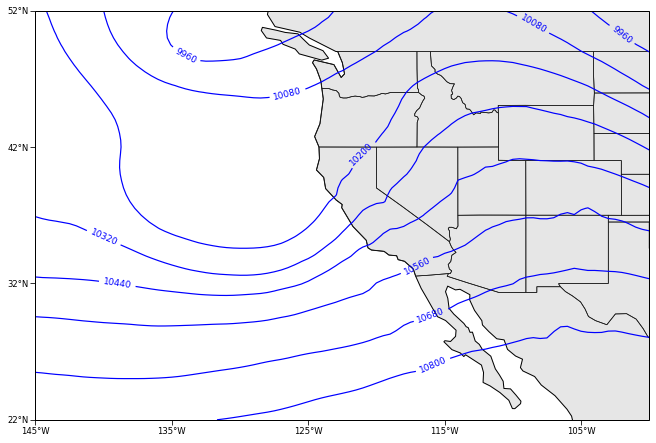

In [43]:
# Create figure
fig = plt.figure(figsize=(11,8)) 

# Add plot axes 
ax = fig.add_subplot(111, projection=mapcrs)
ax.set_extent([lonmin,lonmax,latmin,latmax], crs=mapcrs)

# xticks (longitude tickmarks)
ax.set_xticks(xticks, crs=mapcrs)      
lon_formatter = LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
# yticks (latitude tickmarks)
ax.set_yticks(yticks, crs=mapcrs)
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
# format tickmarks
ax.tick_params(direction='out', # draws ticks outside of plot (`out`,`in`,`inout)
               labelsize=8.5,   # font size of ticklabel,
               length=5,        # lenght of tickmark in points
               pad=2,           # points between tickmark anmd label
               color='black')

# Add map features
ax.add_feature(cfeature.LAND, facecolor='0.9')                    # color fill land gray
ax.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=1.0)  # coastlines
ax.add_feature(cfeature.BORDERS, edgecolor='0.1', linewidth=0.7)  # country borders
ax.add_feature(cfeature.STATES, edgecolor='0.1', linewidth=0.7)   # state borders

# Create arr of contour levels using np.arange(start,stop,interval)
clevs_hgts = np.arange(8400,12800,120)
#print(clevs_hgts)

# Draw contour lines for geop heights 
cs = ax.contour(lons, lats, hgts, transform=datacrs,   # first line= required
                levels=clevs_hgts,  # contour levels
                colors='blue',      # line color
                linewidths=1.2)     # line thickness (default=1.0)
                
# Add labels to contour lines
plt.clabel(cs, fmt='%d', fontsize=9, inline_spacing=5)  

# # Show
plt.show()  


Create a function that will create and return a figure with a background map. This saves us from having to copy/paste lines 1-27 in the previous block each time we create a new map. 

In [44]:
def draw_basemap():

    # Create figure
    fig = plt.figure(figsize=(11,9)) 

    # Add plot axes and draw basemap
    ax = fig.add_subplot(111, projection=mapcrs)
    ax.set_extent([lonmin,lonmax,latmin,latmax], crs=mapcrs)

    # xticks
    ax.set_xticks(xticks, crs=mapcrs)      
    lon_formatter = LongitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    # yticks
    ax.set_yticks(yticks, crs=mapcrs)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    # tick params
    ax.tick_params(direction='out', labelsize=8.5, length=5, pad=2, color='black')    

    # Map features
    ax.add_feature(cfeature.LAND, facecolor='0.9') 
    ax.add_feature(cfeature.COASTLINE, edgecolor='k', linewidth=1.0)
    ax.add_feature(cfeature.BORDERS, edgecolor='0.1', linewidth=0.7)
    ax.add_feature(cfeature.STATES, edgecolor='0.1', linewidth=0.7)
    
    return fig, ax


Use your `draw_basemap` function to create a new figure and background map. Plot height contours, then use `contourf()` to plot filled contours for wind speed (knots). 


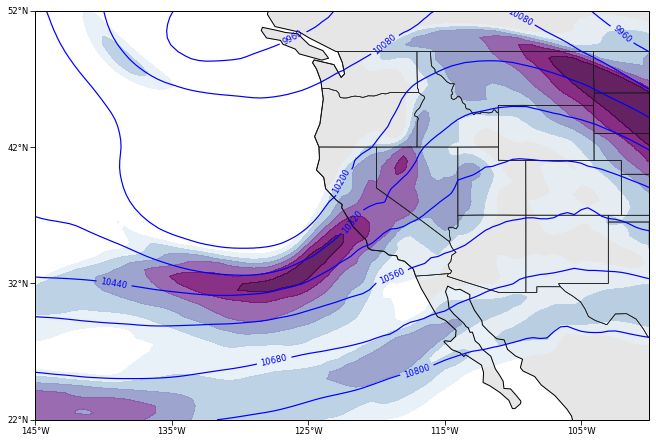

In [45]:
# Draw basemap
fig, ax = draw_basemap()

# Geopotential Heights (contour lines)
clevs_hgts = np.arange(8400,12800,120)
cs = ax.contour(lons, lats, hgts, transform=datacrs,
                levels=clevs_hgts,  # contour levels
                colors='b',         # line color
                linewidths=1.2)     # line thickness
               
# Add labels to contour lines
plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)

# Wind speed - contour fill
clevs_wspd = np.arange(70,121,10)
cf = ax.contourf(lons, lats, wspd_kt, transform=datacrs,
                 levels=clevs_wspd,   
                 cmap='BuPu',       # colormap 
                 extend='max',       
                 alpha=0.8)        # transparency (0=transparent, 1=opaque)


# show
plt.show()


Add wind vectors using `quiver()`

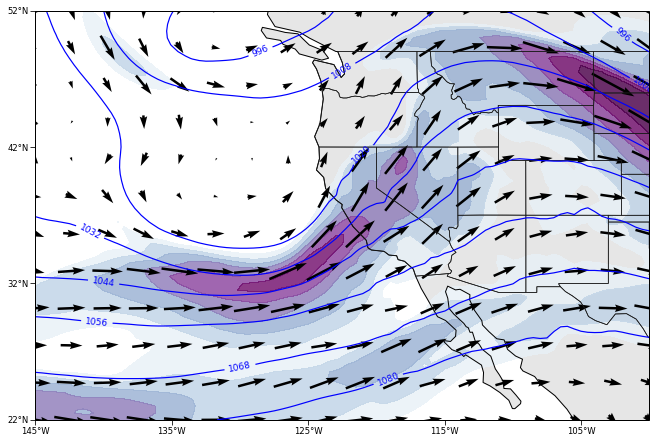

In [46]:
# Draw basemap
fig, ax = draw_basemap()

# Geopotenital height lines
clevs_hgts = np.arange(840,1280,12)
cs = ax.contour(lons, lats, hgts/10., transform=datacrs,
                levels=clevs_hgts,
                colors='b',         # line color
                linewidths=1.2)     # line thickness
               
# Add labels to contour lines
plt.clabel(cs, fmt='%d',fontsize=9, inline_spacing=5)

# Wind speed - contour fill
clevs_wspd = np.arange(70,131,10)
cf = ax.contourf(lons, lats, wspd_kt, transform=datacrs,
                 levels=clevs_wspd, 
                 cmap='BuPu', 
                 extend='max', # use if max data value 
                 alpha=0.8)   # transparency (0=transparent, 1=opaque)

# Wind vectors 
ax.quiver(lons, lats, uwnd, vwnd, transform=datacrs, 
          color='k', 
          pivot='middle',
          regrid_shape=12) # increasing regrid_shape increases the number/density of vectors 

# show
plt.show()


Plot barbs instead of vectors using `barbs()`

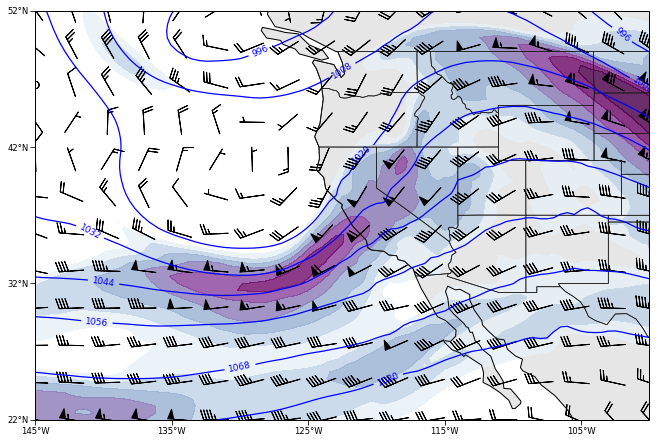

In [49]:
# Draw basemap
fig, ax = draw_basemap()

# Geopotenital height lines
clevs_hgts = np.arange(840,1280,12)
cs = ax.contour(lons, lats, hgts/10., transform=datacrs,
                levels=clevs_hgts,
                colors='b',         # line color
                linewidths=1.25)    # line thickness
               
# Add labels to contour lines
plt.clabel(cs, fmt='%d',fontsize=9, inline_spacing=5)

# Wind speed - contour fill
clevs_wspd = np.arange(70,131,10)
cf = ax.contourf(lons, lats, wspd_kt, transform=datacrs,
                 levels=clevs_wspd, 
                 cmap='BuPu', 
                 extend='max',
                 alpha=0.8)   # transparency (0=transparent, 1=opaque)

# Wind barbs
ax.barbs(lons, lats, uwnd, vwnd, transform=datacrs,    # uses the same args as quiver
          color='k', regrid_shape=12, pivot='middle')  

# show
plt.show()


Add plot elements such as a colorbar and title. Option to save figure.

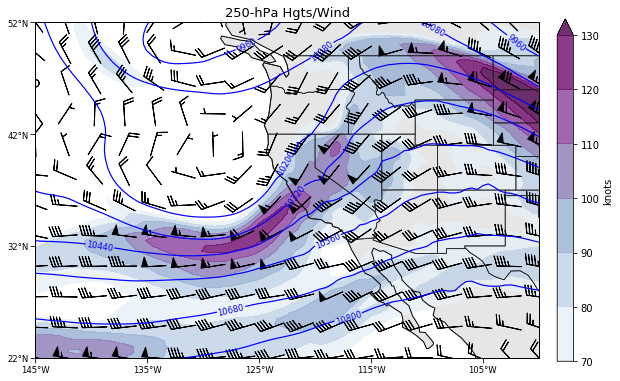

In [54]:
# Draw basemap
fig, ax = draw_basemap()

# Geopotenital height lines
clevs_hgts = np.arange(8400,12800,120)
cs = ax.contour(lons, lats, hgts, transform=datacrs,
                levels=clevs_hgts,
                colors='b',         # line color
                linewidths=1.2)    # line thickness               
# Add labels to contour lines
plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)

# Wind speed - contour fill
clevs_wspd = np.arange(70,131,10)
cf = ax.contourf(lons, lats, wspd_kt, transform=datacrs,
                 levels=clevs_wspd, 
                 cmap='BuPu', 
                 extend='max',
                 alpha=0.8)   # transparency (0=transparent, 1=opaque)

# Wind barbs
ax.barbs(lons, lats, uwnd, vwnd, transform=datacrs,   # uses the same args as quiver
          color='k', regrid_shape=12, pivot='middle')  

# Add colorbar
cb = plt.colorbar(cf, orientation='vertical',  # 'horizontal' or 'vertical'
                  shrink=0.7, pad=0.03)        # fraction to shrink cb by; pad= space between cb and plot
cb.set_label('knots')

# Plot title
titlestring = f"{plev}-hPa Hgts/Wind"                # uses new f-string formatting
ax.set_title(titlestring, loc='center',fontsize=13)  # loc: {'center','right','left'}

# Save figure
outfile = 'map-250hPa.png'
plt.savefig(outfile, 
            bbox_inches='tight',  # trims excess whitespace from around figure
            dpi=300)              # resolution in dots per inch

# show
plt.show()
